## CPOL Rainfall Radar Data and some Machine Learning Algorithms
This notebook applies a bunch of Marchine Learning algorithms, like Support Vector Machine classification, to get some insights about the CPOL radar (extreme) rainfall dataset.

In [194]:
import pandas as pd
import numpy as np
from netCDF4 import Dataset as nc, num2date
import os
from matplotlib import pyplot as plt
import plotly.plotly as py
import plotly.graph_objs as go
import seaborn as sns
import cufflinks as cf
cf.set_config_file(offline=False, world_readable=True, theme='ggplot')
sns.set_style("whitegrid")
from DataFrame import *
from datetime import datetime

Define the path's where data is storde

In [252]:
largeScaleFile = os.path.join(os.environ['HOME'], 'Data', 'Extremes', 'CPOL', 'CPOL-large-scale_forcing.pkl')
largeScaleNc = os.path.join(os.environ['HOME'], 'Data', 'Extremes', 'CPOL', 'CPOL-large-scale_forcing.nc')
CPOL = os.path.join(os.environ['HOME'], 'Data', 'Extremes', 'CPOL', 'CPOL_area_avg_precip.pkl')

#### Load the datasets for CPOL rainfall and Large-scale forcing


In [290]:
cpolFrame = pd.read_pickle(largeScaleFile)
cpol10m = pd.read_pickle(CPOL)['all'] / 6.
cpol1h = cpol10m.groupby(pd.TimeGrouper('1h')).sum()
cpol6h = cpol1h.groupby(pd.TimeGrouper('6h')).mean()
with nc(largeScaleNc) as ncf:
    T = ncf.variables['T'][:]-273.15
    r = ncf.variables['q'][:]/1000.
    plev = ncf.variables['lev'][:]
    times = pd.DatetimeIndex(num2date(ncf.variables['time'][:],ncf.variables['time'].units))
    Ti = num2date(ncf.variables['time'][:],ncf.variables['time'].units)
    prec = np.ma.masked_less(ncf.variables['prec_srf'][:],0).filled(np.nan)
    print(ncf.variables['q'].units)

g/kg


Calculate saturation specific hum. ($E_s$) from temperature and specific hum. ($q$) from mixing ratio ($r$)

In [291]:
a = 6.112 #hPa 
b, c = 17.62, 243.12 #C
d = 0.622
Es = a * np.exp(b * T / (c + T))
q = d * r / (a + r) * 10
qs= d * Es / (plev - 0.378 * Es)
rs = pd.Series(q.sum(axis = -1) / qs.sum(axis = -1),index=times)
cpolFrame['sat_frac_vert'] = rs
cpolFrame['prec_srf'] = prec
cpolFrame['CPOL_rain'] = cpol6h

#cpolFrame['sat_frac_vert'] = pd.Series((q.sum(axis = -1) / qs.sum(axis = -1)), index=times)

In [292]:
cpolFrame.to_pickle(largeScaleFile)

Calculate saturation fraction rs = $int$ q / $int$ qs

#### Make 10 Min Cpol data 6 hourly

#### Create a dataframe with rainfall and some interesting atmos. variables

In [295]:

data = cpolFrame

In [297]:
event = pd.Series(np.zeros(len(data)),index = data.index)
event.loc[data['CPOL_rain'] > data['CPOL_rain'].quantile(90/100.)] = 1.
#event.loc[data['CPOL_rain'] > data['CPOL_rain'].quantile(95/100.)] = 2.
data['Event'] = event

#### Pre-Process the data

In [298]:
from sklearn.cross_validation import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
D = data[['omega-0615hPa','q-0865hPa','Event','PW']].dropna()
exclude = ['lev', 'time', 'lh', 'lh_col', 'lwp', 'pw', 'rh_srf', 'sh','cld','cld_high',
                     'cld_low','cld_mid','cld_thick','cld_top','cld_tot','evap_srf','lw_dn_srf',
                     'lw_net_toa','lw_up_srf','p_srf_aver','p_srf_center','regime','prec_srf','cpol_rain']
values = [v for v in data.keys() if not v.split('-')[0].lower() in exclude]
values_c = ['omega-0715hPa', 'u-0865hPa','s-0715hPa', 's-0865hPa', 'q-0865hPa','dsdt_col','div-0865hPa','sat_frac_vert','Event']
values = ['omega-0715hPa','sat_frac_vert','Event']
D = data[values].dropna()
y = D['Event'].values
del D['Event']
X = D.values
lda = LDA(n_components=3)

from sklearn.cross_validation import train_test_split
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
#X_train = lda.fit_transform(X_train, y_train)
#X_test = lda.transform(X_test)
#print(X_train.shape)

In [339]:
idx = data['Event'] == 1
idx2 = data['Event'] == 0
var = ['omega-0715hPa','q-0865hPa']
bla = data[var].dropna()
scatter = [go.Scatter(
    x=bla.loc[idx][var[0]].values,
    y=bla.loc[idx][var[1]].values,
    #z=data.loc[idx][var[2]].values,
    mode='markers',
    marker=dict(
        size=4,
        line=dict(
            color='rgba(217, 217, 217, 0.14)',
            width=0.5
        ),
        opacity=0.8
    )
),
go.Scatter(
    x=bla.loc[idx2][var[0]].values,
    y=bla.loc[idx2][var[1]].values,
    #z=data.loc[idx2][var[2]].values,
    mode='markers',
    marker=dict(
        size=4,
        line=dict(
            color='red',
            width=0.5
        ),
        opacity=0.8
    )
),
          ]
idx = data['Event'] == 1
idx2 = data['Event'] == 0
var = ['omega-0715hPa','q-0865hPa']
bla = data[var].dropna()
scatter = [go.Scatter(
    x=bla.loc[idx][var[0]].values,
    y=bla.loc[idx][var[1]].values,
    #z=data.loc[idx][var[2]].values,
    mode='markers', 
    name = '>=9th decile',
    marker=dict(
        size=4,
        line=dict(
            color='rgba(217, 217, 217, 0.14)',
            width=0.5
        ),
        opacity=0.8
    )
),
go.Scatter(
    x=bla.loc[idx2][var[0]].values,
    y=bla.loc[idx2][var[1]].values,
    #z=data.loc[idx2][var[2]].values,
    mode='markers',
    name='<9th decile',
    marker=dict(
        size=4,
        line=dict(
            color='red',
            width=0.5
        ),
        opacity=0.8
    )
),
          ]
layout = go.Layout(xaxis=dict(title="omega"), yaxis=dict(title='Humidity'))
py.iplot({'data': scatter, 'layout': layout}, filename='2d_scatter')

In [300]:
###Apply Support Vector Machine Classification

In [301]:
# Fitting Kernel SVM to the Training set
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import RandomForestClassifier
#classifier = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 0)
classifier = SVC(C=1, kernel = 'rbf', degree = 7 ,gamma='auto')
#classifier = LR(tol = 0.01)

classifier.fit(X_train, y_train)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=7, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [302]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
label = {1:'Yes', 0:'No'}
cm

array([[748,   7],
       [ 63,  23]])

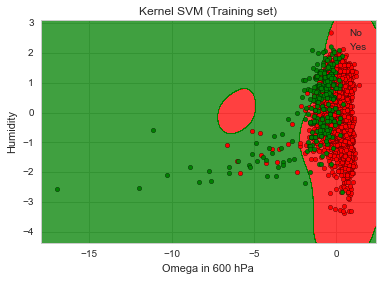

In [303]:
# Visualising the Training set results
from matplotlib.colors import ListedColormap
X_set, y_set = X_train, y_train
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())

for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green'))(i), label = label[i] )
plt.title('Kernel SVM (Training set)')
plt.xlabel('Omega in 600 hPa')
plt.ylabel('Humidity')# Visualising the Test set results
plt.legend()





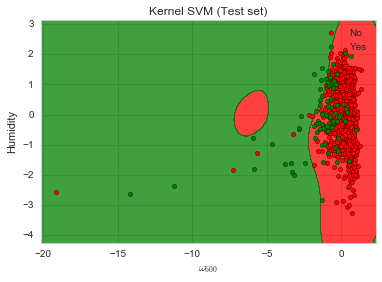

In [304]:
# Visualising the Test set results
from matplotlib.colors import ListedColormap
X_set, y_set = X_test, y_test
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green'))(i), label = label[i])
plt.title('Kernel SVM (Test set)')
plt.ylabel('Humidity')
plt.xlabel('$\\omega_{600}$')
plt.legend()

In [305]:
X_set, y_set = X_test, y_test
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
C = classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape)

#### Now do some cluster analysis

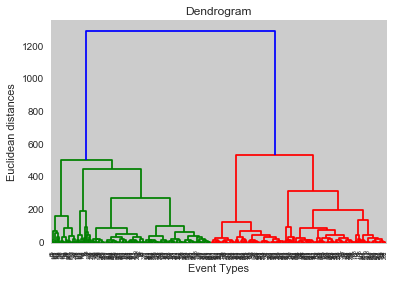

In [306]:
import scipy.cluster.hierarchy as sch
D = data[values_c].dropna()
E = D.loc[D['Event'] == 1]
del E['Event']
dendrogram = sch.dendrogram(sch.linkage(E.values, method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('Event Types')
plt.ylabel('Euclidean distances')
plt.show()

In [342]:
# Fitting Hierarchical Clustering to the dataset
from sklearn.cluster import AgglomerativeClustering
hc = AgglomerativeClustering(n_clusters = 2, affinity = 'euclidean', linkage = 'ward')
y_hc = hc.fit_predict(E.values)

In [343]:
E['Cluster']=pd.Series(y_hc+1,index=E.index)

/home/unimelb.edu.au/mbergemann/.local/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [345]:
c1 = E['Cluster'] == 1
c2 = E['Cluster'] == 2
#c3 = E['Cluster'] == 3

var = ['omega-0715hPa','u-0865hPa','dsdt_col']
bla = E[var]
scatter = [go.Scatter3d(
    x=bla.loc[c1][var[0]].values,
    y=bla.loc[c1][var[1]].values,
    z=bla.loc[c1][var[2]].values,
    name='Cluster #1',
    mode='markers',
    marker=dict(
        size=4,
        line=dict(
            color='rgba(217, 217, 217, 0.14)',
            width=0.5
        ),
        opacity=0.8
    )
),
go.Scatter3d(
    x=bla.loc[c2][var[0]].values,
    y=bla.loc[c2][var[1]].values,
    z=bla.loc[c2][var[2]].values,
    name='Cluster #2',
    mode='markers',
    marker=dict(
        size=4,
        line=dict(
            color='red',
            width=0.5
        ),
        opacity=0.8
    )
),
#go.Scatter3d(
#    x=bla.loc[c3][var[0]].values,
#    y=bla.loc[c3][var[1]].values,
#    z=bla.loc[c3][var[2]].values,
#    name='Cluster #3',
#    mode='markers',
#    marker=dict(
#        size=4,
#        line=dict(
#            color='green',
#            width=0.5
#        ),
#        opacity=0.8
#    )
#),
           
          ]
layout = go.Layout(margin=dict(l=0,r=0,b=0,t=0),scene=go.Scene(xaxis=go.XAxis(title="omega"),
    yaxis=go.YAxis(title='U-Wind'),zaxis=go.ZAxis(title='d(s)/dt')))
py.iplot({'data': scatter, 'layout': layout}, filename='3d_scatter-cluster')

In [ ]:
# 